In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings("ignore")

In [2]:
cat_feat_names = ["workclass", "education_level", "marital-status", "occupation", "relationship", "race", "sex",\
                  "native-country"]
num_feat_names = ["age", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

In [166]:
class Data():
    def __init__(self, csv_file, cat_feats, num_feats):
        self.cat_feats = cat_feats
        self.num_feats = num_feats
        self.num_of_records = None
        self.features = None
        self.target= None
        self.parse_file(csv_file)
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.preprocess()
        self.split_train_test()
    
    def parse_file(self, csv_file):
        df = pd.read_csv(csv_file)
        self.features = df[self.cat_feats + self.num_feats].copy()
        self.target = np.reshape(df["income"].copy().values, (-1,1))
        self.num_of_records = self.features.shape[0]
    
    def log_transformation(self, feature):
        self.features[feature] = self.features[feature].apply(lambda x: np.log(x+1))
    
    def scale_data(self):
        num_values = self.features[self.num_feats].copy()
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(num_values)
        scaled_df = pd.DataFrame(scaled_values, columns=self.num_feats)
        output_df = pd.concat([scaled_df, self.features[self.cat_feats]], axis=1)
        self.features = output_df
    
    def encode_categorical_features(self):
        encoded_df = pd.get_dummies(self.features[self.cat_feats])
        num_vars = self.features[self.num_feats]
        self.features = pd.concat([num_vars, encoded_df], axis=1)
        
    def encode_target(self):
        target_df = pd.DataFrame(self.target, columns=["income"])
        self.target = target_df["income"].map({"<=50K":0, ">50K":1})
    
    def preprocess(self):
        self.log_transformation("capital-loss")
        self.log_transformation("capital-gain")
        self.scale_data()
        self.encode_categorical_features()
        self.encode_target()
        
    def split_train_test(self):
        self.X_train, self.X_test, self.y_train, self.y_test = \
        train_test_split(self.features, self.target, test_size=0.2, random_state = 0)
        
        
        

In [189]:
class Model_Selection():
    def __init__(self, data_, sample_sizes_):
        self.data = data_
        self.models = []
        self.report = {}
        self.validation_scores = {}
        self.sample_sizes = sample_sizes_
        
    def add_model(self, model_):
        self.models.append(model_)
        
    def test_generalization(self):
        for model_ in self.models:
            model_name = model_.__class__.__name__
            model_report = {"training_time": [],
                           "testing_time": [],
                           "fscore_train" : [],
                           "fscore_test":[]}
            for sample_size in self.sample_sizes:
                start_time = time()
                model_.fit(self.data.X_train[:sample_size], self.data.y_train[:sample_size])
                end_time = time()
                training_time = end_time - start_time
                model_report["training_time"].append(training_time)
                
                start_time = time()
                test_predictions = model_.predict(self.data.X_test[:sample_size])
                end_time = time()
                testing_time = end_time - start_time
                model_report["testing_time"].append(testing_time)
                
                train_predictions = model_.predict(self.data.X_train[:sample_size])
                
                train_fscore = fbeta_score(self.data.y_train[:sample_size], train_predictions, beta=0.5)
                test_fscore = fbeta_score(self.data.y_test[:sample_size], test_predictions, beta=0.5)
                model_report["fscore_train"].append(train_fscore)
                model_report["fscore_test"].append(test_fscore)
                
            self.report[model_name] = model_report
            
        def cross_validate(self, k):
            scorer = make_scorer(fbeta_score, beta=0.5)
            for model in self.models:
                val_score = dict()
                cross_val_results = cross_val_score(model, self.data.X_train, self.data.y_train, scoring=scorer)
                val_score["fscore_mean"] = np.mean(cross_val_results)
                val_score["fscore_std"] = np.std(cross_val_results)
                self.validation_scores[model.__class__.__name___]
                
    
    def summarize(self):
        for model in self.models:
            print("Report: {}".format(model.__class__.__name__))
            model_report = self.report[model.__class__.__name__]
            plt.figure()
            plt.subplots_adjust(wspace=0.5, hspace=0.5)
            plt.subplot(221)
            plt.title("Training Time")
            plt.plot(self.sample_sizes, model_report["training_time"])
            
            plt.subplot(222)
            plt.title("Testing Time")
            plt.plot(self.sample_sizes, model_report["testing_time"])
            
            plt.subplot(223)
            plt.title("F beta score for training set")
            plt.plot(self.sample_sizes, model_report["fscore_train"])
            plt.ylim((0.5,1))
            
            plt.subplot(224)
            plt.title("F beta score for testing set")
            plt.plot(self.sample_sizes, model_report["fscore_test"])
            plt.ylim((0.5,1))
            print("\n")

        

In [190]:
samples_sizes = [452, 4522, 45222]
logist_regression = LogisticRegression()
grad_boost = GradientBoostingClassifier()
gaussian_NB = GaussianNB()

data_ = Data("census.csv",cat_feat_names, num_feat_names)
model_selector = Model_Selection(data_, samples_sizes)
model_selector.add_model(logist_regression)
model_selector.add_model(grad_boost)
model_selector.add_model(gaussian_NB)
model_selector.test_generalization()

Report: LogisticRegression


Report: GradientBoostingClassifier


Report: GaussianNB




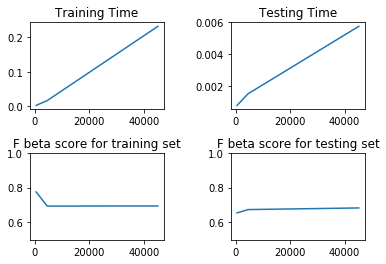

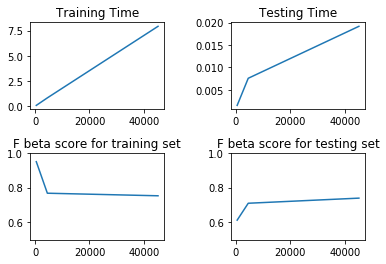

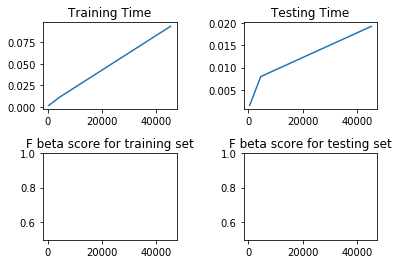

In [191]:
model_selector.summarize()